# Applying Autoencoders to BRCA DNA Methylation data from TCGA 

In [2]:
import joblib
import pandas as pd
# http://localhost:8888/edit/ae_integration/multomics_ae/pancancer_meth_chr_nonna_fillnamean.pkl
meth_df_path =  "pancancer_meth_chr_nonna_fillnamean.pkl"
pancancer_meth_list = joblib.load(meth_df_path)
len(pancancer_meth_list)

23

In [39]:
for chro in pancancer_meth_list:
    print(chro.shape)

(9756, 19012)
(9756, 9892)
(9756, 11802)
(9756, 9905)
(9756, 4874)
(9756, 6170)
(9756, 6223)
(9756, 8982)
(9756, 11703)
(9756, 2504)
(9756, 10525)
(9756, 14015)
(9756, 4325)
(9756, 1613)
(9756, 3497)
(9756, 10071)
(9756, 7963)
(9756, 9821)
(9756, 14590)
(9756, 12024)
(9756, 8234)
(9756, 4018)
(9756, 4863)


In [4]:
mv_pancancer_meth_list = []
for df in pancancer_meth_list:
    no_features = int(df.shape[1]/2)
    most_variable_genes = df.mad(axis = 0).nlargest(no_features, keep='all').index.values.tolist()
    #Subseting the genes from mvg_v3_df that are on the most_variable_genes list
    mvf_df = df[most_variable_genes]
    mv_pancancer_meth_list.append(mvf_df)
len(mv_pancancer_meth_list)

# ## Saving the list of chromosome dataframe
# joblib.dump(mv_pancancer_meth_list, "pancancer_meth_top50percent_chr_nonna_fillnamean.pkl")

23

In [5]:
for chro in mv_pancancer_meth_list:
    print(chro.shape)

(9756, 19012)
(9756, 9892)
(9756, 11802)
(9756, 9905)
(9756, 4874)
(9756, 6170)
(9756, 6223)
(9756, 8982)
(9756, 11703)
(9756, 2504)
(9756, 10525)
(9756, 14015)
(9756, 4325)
(9756, 1613)
(9756, 3497)
(9756, 10071)
(9756, 7963)
(9756, 9821)
(9756, 14590)
(9756, 12024)
(9756, 8234)
(9756, 4018)
(9756, 4863)


In [6]:
pancancer_meth_list = mv_pancancer_meth_list

In [1]:
import joblib
pancancer_meth_list = joblib.load("pancancer_meth_top50percent_chr_nonna_fillnamean.pkl")

### 5. Building a Vanilla Autoencoder

In [2]:
import tensorflow as tf
# print(tf.__version__)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K #For explicitly \adjusting the learning rate

In [4]:
from numpy.random import seed
seed(1)

tf.random.set_seed(2)


In [5]:
X_train, X_val = train_test_split(pancancer_meth_list[0], test_size=0.2, random_state = seed(77))
#Since the samples will be split similarly across all chromosomes, we shall match the indices for 
# X_train and X_val across all chr
training_indices = X_train.index
validation_indices = X_val.index

X_train_list = []
X_val_list = []
for chrom_df in pancancer_meth_list:
    X_train_list.append(chrom_df.loc[training_indices])
    X_val_list.append(chrom_df.loc[validation_indices])

In [6]:
tf.keras.backend.clear_session()
ncol_list = []
for df in pancancer_meth_list:
    ncol_list.append(df.shape[1])
    
number_of_chromosomes = len(pancancer_meth_list)

chromsomome_dim = 100 # 100*23
hidden_layer_dim = 500 
encoding_dim = 100 #Nodes in Bottleneck layer

# Encoder Layers
encoded1_list = []
input_dim_list = []
for ncol in ncol_list:
    input_dim_i = Input(shape = (ncol, ))
    input_dim_list.append(input_dim_i)
    encoded1_i = Dense(chromsomome_dim, activation = 'relu')(input_dim_i)
#     input_model = Model(inputs=input_dim_i, outputs=encoded1_i)
    encoded1_list.append(encoded1_i)

# encoded1 = concatenate(encoded1_list)
encoded1 = Concatenate(axis=1)(encoded1_list)
encoded2 = Dense(hidden_layer_dim, activation = 'relu')(encoded1)
encoded3 = Dense(encoding_dim, activation = 'relu')(encoded2)

# Decoder Layers
decoded3 = Dense(hidden_layer_dim, activation = 'relu')(encoded3)
decoded2 = Dense(chromsomome_dim*number_of_chromosomes, activation = 'relu')(decoded3)
reconstructured_inputs = []
for i in range(0,number_of_chromosomes):
    start = chromsomome_dim*(i)
    end = chromsomome_dim*(i+1)
    decoded2_i = decoded2[:,start:end] #Splicing the tensor back to chromsomome_dim*23 tensors
    decoded1_i = Dense(ncol_list[i], activation = 'sigmoid')(decoded2_i)
#     output_model = Model(inputs=decoded2_i, outputs=decoded1_i)
#     reconstructured_inputs.append(output_model.output)
    reconstructured_inputs.append(decoded1_i)
    
autoencoder = Model(inputs = input_dim_list, outputs = reconstructured_inputs)

In [7]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19012)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9892)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 11802)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 9905)]       0           []                               
                                                                                              

 dense_17 (Dense)               (None, 100)          982200      ['input_18[0][0]']               
                                                                                                  
 dense_18 (Dense)               (None, 100)          1459100     ['input_19[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 100)          1202500     ['input_20[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 100)          823500      ['input_21[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 100)          401900      ['input_22[0][0]']               
                                                                                                  
 dense_22 

 tf.__operators__.getitem_13 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_14 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_15 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_16 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpL

                                                                                                  
 dense_45 (Dense)               (None, 14590)        1473590     ['tf.__operators__.getitem_18[0][
                                                                 0]']                             
                                                                                                  
 dense_46 (Dense)               (None, 12024)        1214424     ['tf.__operators__.getitem_19[0][
                                                                 0]']                             
                                                                                                  
 dense_47 (Dense)               (None, 8234)         831634      ['tf.__operators__.getitem_20[0][
                                                                 0]']                             
                                                                                                  
 dense_48 

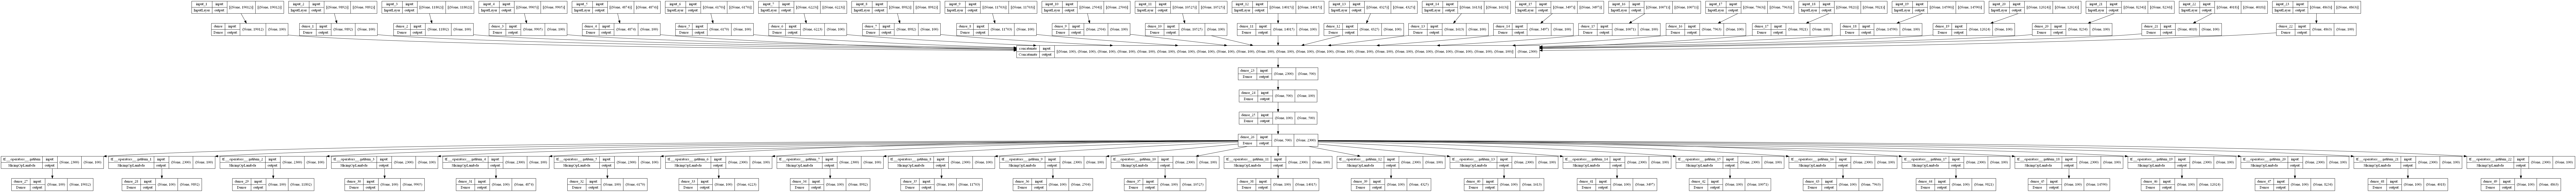

In [8]:
#Plotting the model
# !pip install pydot
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, show_shapes=True, show_layer_names=True) #to_file='model_plot.png', )

In [9]:
#MODEL Parameters
def averaged_mean_squared_error(y_true, y_pred):
        return (K.sqrt(K.mean(K.square(y_pred - y_true))))/number_of_chromosomes

# Compile the Model
autoencoder.compile(optimizer = 'adam', loss = 'mse') 

#adam - stochastic gradient descent algorithm

# K.set_value(autoencoder.optimizer.learning_rate, 0.0001)


In [10]:
#Implementing Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime

learning_rate = ReduceLROnPlateau(monitor='val_loss',patience=20, verbose=1, factor=0.5, min_lr=1e-10)

# earlystopping_callback = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# import h5py
# !pip install --upgrade h5py=1.8.21
# #Saving best Model after the Stopping
# mc = ModelCheckpoint('meth_ae_v1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [11]:
print(log_dir)

logs/fit/20220420-111237


In [12]:
history = autoencoder.fit(X_train_list, X_train_list, epochs = 100, batch_size = 64, shuffle = False, verbose = 1, validation_data = (X_val_list, X_val_list), callbacks=[learning_rate,tensorboard_callback])

Epoch 1/100
122/122 [==============================] - 24s 157ms/step - loss: 0.8604 - dense_27_loss: 0.0368 - dense_28_loss: 0.0388 - dense_29_loss: 0.0365 - dense_30_loss: 0.0383 - dense_31_loss: 0.0403 - dense_32_loss: 0.0370 - dense_33_loss: 0.0368 - dense_34_loss: 0.0349 - dense_35_loss: 0.0357 - dense_36_loss: 0.0382 - dense_37_loss: 0.0334 - dense_38_loss: 0.0386 - dense_39_loss: 0.0369 - dense_40_loss: 0.0385 - dense_41_loss: 0.0337 - dense_42_loss: 0.0374 - dense_43_loss: 0.0380 - dense_44_loss: 0.0403 - dense_45_loss: 0.0371 - dense_46_loss: 0.0397 - dense_47_loss: 0.0403 - dense_48_loss: 0.0352 - dense_49_loss: 0.0380 - val_loss: 0.7131 - val_dense_27_loss: 0.0311 - val_dense_28_loss: 0.0325 - val_dense_29_loss: 0.0304 - val_dense_30_loss: 0.0320 - val_dense_31_loss: 0.0341 - val_dense_32_loss: 0.0307 - val_dense_33_loss: 0.0312 - val_dense_34_loss: 0.0295 - val_dense_35_loss: 0.0302 - val_dense_36_loss: 0.0313 - val_dense_37_loss: 0.0278 - val_dense_38_loss: 0.0330 - val_de

122/122 [==============================] - 12s 101ms/step - loss: 0.3395 - dense_27_loss: 0.0142 - dense_28_loss: 0.0153 - dense_29_loss: 0.0145 - dense_30_loss: 0.0150 - dense_31_loss: 0.0159 - dense_32_loss: 0.0146 - dense_33_loss: 0.0146 - dense_34_loss: 0.0135 - dense_35_loss: 0.0138 - dense_36_loss: 0.0153 - dense_37_loss: 0.0135 - dense_38_loss: 0.0150 - dense_39_loss: 0.0142 - dense_40_loss: 0.0153 - dense_41_loss: 0.0129 - dense_42_loss: 0.0148 - dense_43_loss: 0.0153 - dense_44_loss: 0.0165 - dense_45_loss: 0.0151 - dense_46_loss: 0.0156 - dense_47_loss: 0.0160 - dense_48_loss: 0.0139 - dense_49_loss: 0.0146 - val_loss: 0.3502 - val_dense_27_loss: 0.0147 - val_dense_28_loss: 0.0157 - val_dense_29_loss: 0.0149 - val_dense_30_loss: 0.0155 - val_dense_31_loss: 0.0164 - val_dense_32_loss: 0.0151 - val_dense_33_loss: 0.0151 - val_dense_34_loss: 0.0138 - val_dense_35_loss: 0.0142 - val_dense_36_loss: 0.0158 - val_dense_37_loss: 0.0139 - val_dense_38_loss: 0.0155 - val_dense_39_loss:

122/122 [==============================] - 12s 101ms/step - loss: 0.3144 - dense_27_loss: 0.0132 - dense_28_loss: 0.0143 - dense_29_loss: 0.0134 - dense_30_loss: 0.0138 - dense_31_loss: 0.0147 - dense_32_loss: 0.0135 - dense_33_loss: 0.0135 - dense_34_loss: 0.0124 - dense_35_loss: 0.0128 - dense_36_loss: 0.0142 - dense_37_loss: 0.0126 - dense_38_loss: 0.0139 - dense_39_loss: 0.0132 - dense_40_loss: 0.0141 - dense_41_loss: 0.0119 - dense_42_loss: 0.0137 - dense_43_loss: 0.0141 - dense_44_loss: 0.0154 - dense_45_loss: 0.0141 - dense_46_loss: 0.0144 - dense_47_loss: 0.0148 - dense_48_loss: 0.0128 - dense_49_loss: 0.0137 - val_loss: 0.3166 - val_dense_27_loss: 0.0132 - val_dense_28_loss: 0.0143 - val_dense_29_loss: 0.0134 - val_dense_30_loss: 0.0139 - val_dense_31_loss: 0.0149 - val_dense_32_loss: 0.0135 - val_dense_33_loss: 0.0136 - val_dense_34_loss: 0.0125 - val_dense_35_loss: 0.0128 - val_dense_36_loss: 0.0144 - val_dense_37_loss: 0.0128 - val_dense_38_loss: 0.0140 - val_dense_39_loss:

122/122 [==============================] - 12s 100ms/step - loss: 0.3073 - dense_27_loss: 0.0129 - dense_28_loss: 0.0139 - dense_29_loss: 0.0131 - dense_30_loss: 0.0135 - dense_31_loss: 0.0144 - dense_32_loss: 0.0132 - dense_33_loss: 0.0133 - dense_34_loss: 0.0121 - dense_35_loss: 0.0125 - dense_36_loss: 0.0138 - dense_37_loss: 0.0123 - dense_38_loss: 0.0136 - dense_39_loss: 0.0129 - dense_40_loss: 0.0137 - dense_41_loss: 0.0116 - dense_42_loss: 0.0133 - dense_43_loss: 0.0138 - dense_44_loss: 0.0151 - dense_45_loss: 0.0137 - dense_46_loss: 0.0141 - dense_47_loss: 0.0145 - dense_48_loss: 0.0125 - dense_49_loss: 0.0135 - val_loss: 0.3076 - val_dense_27_loss: 0.0128 - val_dense_28_loss: 0.0140 - val_dense_29_loss: 0.0131 - val_dense_30_loss: 0.0136 - val_dense_31_loss: 0.0144 - val_dense_32_loss: 0.0132 - val_dense_33_loss: 0.0133 - val_dense_34_loss: 0.0121 - val_dense_35_loss: 0.0125 - val_dense_36_loss: 0.0139 - val_dense_37_loss: 0.0123 - val_dense_38_loss: 0.0136 - val_dense_39_loss:

122/122 [==============================] - 12s 100ms/step - loss: 0.3031 - dense_27_loss: 0.0126 - dense_28_loss: 0.0137 - dense_29_loss: 0.0129 - dense_30_loss: 0.0133 - dense_31_loss: 0.0142 - dense_32_loss: 0.0130 - dense_33_loss: 0.0131 - dense_34_loss: 0.0119 - dense_35_loss: 0.0123 - dense_36_loss: 0.0136 - dense_37_loss: 0.0121 - dense_38_loss: 0.0133 - dense_39_loss: 0.0127 - dense_40_loss: 0.0134 - dense_41_loss: 0.0115 - dense_42_loss: 0.0131 - dense_43_loss: 0.0136 - dense_44_loss: 0.0150 - dense_45_loss: 0.0135 - dense_46_loss: 0.0139 - dense_47_loss: 0.0143 - dense_48_loss: 0.0124 - dense_49_loss: 0.0135 - val_loss: 0.3106 - val_dense_27_loss: 0.0130 - val_dense_28_loss: 0.0141 - val_dense_29_loss: 0.0132 - val_dense_30_loss: 0.0137 - val_dense_31_loss: 0.0145 - val_dense_32_loss: 0.0132 - val_dense_33_loss: 0.0134 - val_dense_34_loss: 0.0123 - val_dense_35_loss: 0.0126 - val_dense_36_loss: 0.0141 - val_dense_37_loss: 0.0125 - val_dense_38_loss: 0.0137 - val_dense_39_loss:

122/122 [==============================] - 12s 100ms/step - loss: 0.3005 - dense_27_loss: 0.0125 - dense_28_loss: 0.0136 - dense_29_loss: 0.0128 - dense_30_loss: 0.0132 - dense_31_loss: 0.0141 - dense_32_loss: 0.0130 - dense_33_loss: 0.0129 - dense_34_loss: 0.0118 - dense_35_loss: 0.0122 - dense_36_loss: 0.0135 - dense_37_loss: 0.0120 - dense_38_loss: 0.0132 - dense_39_loss: 0.0126 - dense_40_loss: 0.0133 - dense_41_loss: 0.0114 - dense_42_loss: 0.0130 - dense_43_loss: 0.0135 - dense_44_loss: 0.0149 - dense_45_loss: 0.0134 - dense_46_loss: 0.0138 - dense_47_loss: 0.0142 - dense_48_loss: 0.0123 - dense_49_loss: 0.0133 - val_loss: 0.3049 - val_dense_27_loss: 0.0127 - val_dense_28_loss: 0.0138 - val_dense_29_loss: 0.0129 - val_dense_30_loss: 0.0134 - val_dense_31_loss: 0.0142 - val_dense_32_loss: 0.0131 - val_dense_33_loss: 0.0131 - val_dense_34_loss: 0.0121 - val_dense_35_loss: 0.0124 - val_dense_36_loss: 0.0137 - val_dense_37_loss: 0.0124 - val_dense_38_loss: 0.0134 - val_dense_39_loss:

122/122 [==============================] - 12s 101ms/step - loss: 0.3001 - dense_27_loss: 0.0125 - dense_28_loss: 0.0136 - dense_29_loss: 0.0127 - dense_30_loss: 0.0132 - dense_31_loss: 0.0141 - dense_32_loss: 0.0129 - dense_33_loss: 0.0129 - dense_34_loss: 0.0118 - dense_35_loss: 0.0121 - dense_36_loss: 0.0135 - dense_37_loss: 0.0120 - dense_38_loss: 0.0132 - dense_39_loss: 0.0126 - dense_40_loss: 0.0133 - dense_41_loss: 0.0113 - dense_42_loss: 0.0130 - dense_43_loss: 0.0134 - dense_44_loss: 0.0149 - dense_45_loss: 0.0134 - dense_46_loss: 0.0138 - dense_47_loss: 0.0142 - dense_48_loss: 0.0123 - dense_49_loss: 0.0133 - val_loss: 0.3038 - val_dense_27_loss: 0.0127 - val_dense_28_loss: 0.0139 - val_dense_29_loss: 0.0129 - val_dense_30_loss: 0.0133 - val_dense_31_loss: 0.0143 - val_dense_32_loss: 0.0131 - val_dense_33_loss: 0.0131 - val_dense_34_loss: 0.0120 - val_dense_35_loss: 0.0123 - val_dense_36_loss: 0.0137 - val_dense_37_loss: 0.0122 - val_dense_38_loss: 0.0134 - val_dense_39_loss:

122/122 [==============================] - 12s 100ms/step - loss: 0.2960 - dense_27_loss: 0.0123 - dense_28_loss: 0.0134 - dense_29_loss: 0.0126 - dense_30_loss: 0.0130 - dense_31_loss: 0.0139 - dense_32_loss: 0.0128 - dense_33_loss: 0.0127 - dense_34_loss: 0.0116 - dense_35_loss: 0.0119 - dense_36_loss: 0.0133 - dense_37_loss: 0.0118 - dense_38_loss: 0.0130 - dense_39_loss: 0.0125 - dense_40_loss: 0.0131 - dense_41_loss: 0.0112 - dense_42_loss: 0.0128 - dense_43_loss: 0.0133 - dense_44_loss: 0.0147 - dense_45_loss: 0.0132 - dense_46_loss: 0.0136 - dense_47_loss: 0.0140 - dense_48_loss: 0.0122 - dense_49_loss: 0.0132 - val_loss: 0.3027 - val_dense_27_loss: 0.0126 - val_dense_28_loss: 0.0137 - val_dense_29_loss: 0.0129 - val_dense_30_loss: 0.0133 - val_dense_31_loss: 0.0143 - val_dense_32_loss: 0.0130 - val_dense_33_loss: 0.0129 - val_dense_34_loss: 0.0119 - val_dense_35_loss: 0.0122 - val_dense_36_loss: 0.0137 - val_dense_37_loss: 0.0122 - val_dense_38_loss: 0.0133 - val_dense_39_loss:

122/122 [==============================] - 12s 101ms/step - loss: 0.2993 - dense_27_loss: 0.0124 - dense_28_loss: 0.0136 - dense_29_loss: 0.0127 - dense_30_loss: 0.0131 - dense_31_loss: 0.0140 - dense_32_loss: 0.0129 - dense_33_loss: 0.0129 - dense_34_loss: 0.0118 - dense_35_loss: 0.0120 - dense_36_loss: 0.0135 - dense_37_loss: 0.0120 - dense_38_loss: 0.0132 - dense_39_loss: 0.0126 - dense_40_loss: 0.0133 - dense_41_loss: 0.0113 - dense_42_loss: 0.0129 - dense_43_loss: 0.0134 - dense_44_loss: 0.0148 - dense_45_loss: 0.0133 - dense_46_loss: 0.0137 - dense_47_loss: 0.0141 - dense_48_loss: 0.0123 - dense_49_loss: 0.0133 - val_loss: 0.3067 - val_dense_27_loss: 0.0127 - val_dense_28_loss: 0.0139 - val_dense_29_loss: 0.0130 - val_dense_30_loss: 0.0135 - val_dense_31_loss: 0.0143 - val_dense_32_loss: 0.0131 - val_dense_33_loss: 0.0132 - val_dense_34_loss: 0.0121 - val_dense_35_loss: 0.0124 - val_dense_36_loss: 0.0138 - val_dense_37_loss: 0.0125 - val_dense_38_loss: 0.0135 - val_dense_39_loss:

dict_keys(['loss', 'dense_27_loss', 'dense_28_loss', 'dense_29_loss', 'dense_30_loss', 'dense_31_loss', 'dense_32_loss', 'dense_33_loss', 'dense_34_loss', 'dense_35_loss', 'dense_36_loss', 'dense_37_loss', 'dense_38_loss', 'dense_39_loss', 'dense_40_loss', 'dense_41_loss', 'dense_42_loss', 'dense_43_loss', 'dense_44_loss', 'dense_45_loss', 'dense_46_loss', 'dense_47_loss', 'dense_48_loss', 'dense_49_loss', 'val_loss', 'val_dense_27_loss', 'val_dense_28_loss', 'val_dense_29_loss', 'val_dense_30_loss', 'val_dense_31_loss', 'val_dense_32_loss', 'val_dense_33_loss', 'val_dense_34_loss', 'val_dense_35_loss', 'val_dense_36_loss', 'val_dense_37_loss', 'val_dense_38_loss', 'val_dense_39_loss', 'val_dense_40_loss', 'val_dense_41_loss', 'val_dense_42_loss', 'val_dense_43_loss', 'val_dense_44_loss', 'val_dense_45_loss', 'val_dense_46_loss', 'val_dense_47_loss', 'val_dense_48_loss', 'val_dense_49_loss', 'lr'])


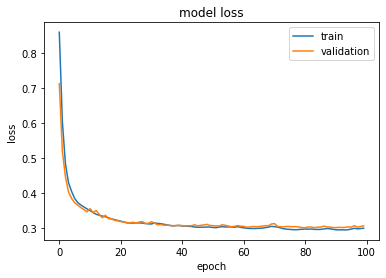

In [13]:
#Visualizing the Loss over epochs
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [14]:
# save model and architecture to single file
autoencoder.save("./pancan_meth_chr_blocks_50%mad_ae_model.h5")
print("Saved model to disk")

# from keras.models import model_from_json
# ## Saving and Loading the Model
# # serialize model to JSON
# model_json = Model.to_json()
# with open("pancan_meth_chr_blocks_ae_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# Model.save_weights("pancan_meth_chr_blocks_ae_model.h5")
# print("Saved model to disk")
 
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [15]:
tf.keras.backend.clear_session()

In [16]:
with tf.device('/gpu:1'):
    encoder = Model(inputs = input_dim_list, outputs = encoded3)
    encoded_train = pd.DataFrame(encoder.predict(pancancer_meth_list), index=pancancer_meth_list[0].index) #Maintain Index for Mapping to cancer type 
    encoded_train = encoded_train.add_prefix('feature_')
    encoded_train.shape

In [17]:
# from tensorflow import keras
# temp_model = keras.models.load_model("pancan_meth_chr_blocks_50%mad_ae_model.h5")
# temp_model
# input_list = []
# for i in range (0,23):
#     input_list.append(temp_model.layers[i].input)
# input_list
# output = temp_model.layers[48].output
# encoder_fitter = Model(inputs = input_list, outputs = output)

# encoded_train = pd.DataFrame(encoder_fitter.predict(pancancer_meth_list), index=pancancer_meth_list[0].index) #Maintain Index for Mapping to cancer type 
# encoded_train = encoded_train.add_prefix('feature_')
# encoded_train.shape

In [18]:
#output dataset
shape_before_removing_nan = encoded_train.shape
encoded_train.replace(0, np.nan, inplace=True) #Converting all the zero's to nan to use nan command
encoded_train.dropna(how='all',axis=1, inplace=True) #Removing columns with all nan rows
encoded_train.dropna(how='all',axis=0, inplace=True) #Removing rows with all nan columns
encoded_train.replace(np.nan, 0, inplace=True) #Converting all the nan's to zero to be compatible with t-SNE
print(shape_before_removing_nan, encoded_train.shape)

encoded_train.to_csv("LatentFeatures_PanCan_Meth_AE_chr_top50%MAD.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

(9756, 100) (9756, 52)


In [19]:
encoded_train.head()

,,,,,feature_0,feature_1,feature_3,feature_4,feature_5,feature_6,feature_9,feature_12,feature_13,feature_15,...,feature_85,feature_86,feature_90,feature_91,feature_92,feature_94,feature_96,feature_97,feature_98,feature_99
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,15.799934,3.540356,8.319631,11.338633,13.307392,8.876436,0.000000,3.214633,...,7.269497,0.0,0.0,9.833212,8.776689,0.0,0.000000,0.0,8.303660,3.250827
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,16.392843,9.270647,6.637997,17.993500,17.662289,8.911863,0.000000,3.119030,...,7.758270,0.0,0.0,6.206025,7.218666,0.0,0.000000,0.0,7.218194,0.000000
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,22.294445,5.920326,5.956043,9.445713,28.543646,7.965502,2.242851,2.230719,...,6.839697,0.0,0.0,2.103398,6.932590,0.0,0.000000,0.0,11.307303,2.181861
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,12.439379,8.374991,4.556692,12.214819,13.260650,3.242250,0.000000,6.918120,...,8.056440,0.0,0.0,8.070397,3.801511,0.0,0.000000,0.0,6.007840,0.000000
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,16.835310,8.505275,3.196869,12.884025,21.618933,8.171265,0.000000,1.796970,...,6.855167,0.0,0.0,0.000000,8.095356,0.0,0.159967,0.0,9.027602,0.990263


In [ ]:
# encoded_train.to_csv("Meth_AE_v2.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

In [20]:
#Scaling these features to -1,1 range for applying tsne
from sklearn.preprocessing import MinMaxScaler
feature_list = encoded_train.columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
encoded_train[feature_list] = scaler.fit_transform(encoded_train[feature_list])

In [21]:
encoded_train.head()

,,,,,feature_0,feature_1,feature_3,feature_4,feature_5,feature_6,feature_9,feature_12,feature_13,feature_15,...,feature_85,feature_86,feature_90,feature_91,feature_92,feature_94,feature_96,feature_97,feature_98,feature_99
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,0.599799,0.207917,0.313077,0.630152,0.379497,0.570087,0.000000,0.189210,...,0.415144,0.0,0.0,0.425218,0.371607,0.0,0.000000,0.0,0.362016,0.163605
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,0.622308,0.544444,0.249795,1.000000,0.503689,0.572362,0.000000,0.183583,...,0.443057,0.0,0.0,0.268367,0.305640,0.0,0.000000,0.0,0.314693,0.000000
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,0.846345,0.347687,0.224132,0.524951,0.814001,0.511582,0.144693,0.131298,...,0.390599,0.0,0.0,0.090957,0.293527,0.0,0.000000,0.0,0.492967,0.109807
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,0.472226,0.491844,0.171473,0.678846,0.378164,0.208233,0.000000,0.407194,...,0.460085,0.0,0.0,0.348988,0.160957,0.0,0.000000,0.0,0.261925,0.000000
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.0,0.0,0.639104,0.499495,0.120302,0.716038,0.616524,0.524797,0.000000,0.105768,...,0.391483,0.0,0.0,0.000000,0.342759,0.0,0.010487,0.0,0.393578,0.049837


### 6. Dimension Reduction and Cluster Visualization using t-SNE 


perplexity parameter can be changed based on the input datatset - dataset with larger number of variables requires larger perplexity set this value between 5 and 50 (sklearn documentation) verbose=1 displays run time messages set n_iter sufficiently high to resolve the well stabilized cluster get embeddings


In [22]:
# Perform t-SNE on AE encoded_features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=40, learning_rate=300, n_iter=400, verbose=1)
tsne_out = tsne.fit_transform(encoded_train)
# tsne_out = TSNE(n_components=2, perplexity=105, n_iter=1000, verbose=1).fit_transform(encoded_train)
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9756 samples in 0.001s...
[t-SNE] Computed neighbors for 9756 samples in 3.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9756
[t-SNE] Computed conditional probabilities for sample 2000 / 9756
[t-SNE] Computed conditional probabilities for sample 3000 / 9756
[t-SNE] Computed conditional probabilities for sample 4000 / 9756
[t-SNE] Computed conditional probabilities for sample 5000 / 9756
[t-SNE] Computed conditional probabilities for sample 6000 / 9756
[t-SNE] Computed conditional probabilities for sample 7000 / 9756
[t-SNE] Computed conditional probabilities for sample 8000 / 9756
[t-SNE] Computed conditional probabilities for sample 9000 / 9756
[t-SNE] Computed conditional probabilities for sample 9756 / 9756
[t-SNE] Mean sigma: 0.226713


C:\Users\ssrikrishnan6\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.955124
[t-SNE] KL divergence after 400 iterations: 1.500113


In [23]:
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index
tsne_components.head()

,,,,,0,1
patient,sample,sample_type,aliquot,file,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-7.906489,-9.246474
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-8.150885,-10.113232
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-9.041054,-9.915301
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-7.494098,-10.144774
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-8.514006,-10.136643


### 7. Mapping samples to cancer type


In [24]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)

new_patient_indices = []
for index in patient_metadata.index:
    new_patient_indices.append("-".join(index.split("-")[:-3]))
patient_metadata.index = new_patient_indices

In [25]:
patient_metadata.index 

Index(['TCGA-NC-A5HI-01A', 'TCGA-68-8251-01A', 'TCGA-98-A53A-01A',
       'TCGA-39-5029-01A', 'TCGA-22-5474-01A', 'TCGA-CN-5355-01A',
       'TCGA-CV-7235-01A', 'TCGA-CV-5440-01A', 'TCGA-MT-A51X-01A',
       'TCGA-CQ-5331-01A',
       ...
       'TCGA-CH-5740-01A', 'TCGA-J4-A67M-01A', 'TCGA-M7-A723-01A',
       'TCGA-HC-7075-01A', 'TCGA-CH-5741-01A', 'TCGA-YL-A9WL-01A',
       'TCGA-KK-A5A1-01A', 'TCGA-HU-A4H6-01A', 'TCGA-BR-8291-01A',
       'TCGA-BR-4253-01A'],
      dtype='object', length=11093)

In [26]:
new_indices = []
for index in tsne_components.index:
    new_index = index[1]
    new_indices.append(new_index)
tsne_components.index = new_indices

# new_tsne_components = tsne_components.copy()
# new_tsne_components.index = new_indices

# #Merging based on tcga_id
grouped_tsne = pd.merge(tsne_components , patient_metadata['cancer_type'] , left_index=True, right_index=True)

print(grouped_tsne.shape)
grouped_tsne.head()

(9151, 3)


,0,1,cancer_type
TCGA-05-4384-01A,8.425465,-8.400389,TCGA-LUAD
TCGA-05-4390-01A,7.289073,-4.908593,TCGA-LUAD
TCGA-05-4396-01A,7.515549,-9.001557,TCGA-LUAD
TCGA-05-4405-01A,5.389560,-5.333567,TCGA-LUAD
TCGA-05-4410-01A,9.838059,-5.947622,TCGA-LUAD


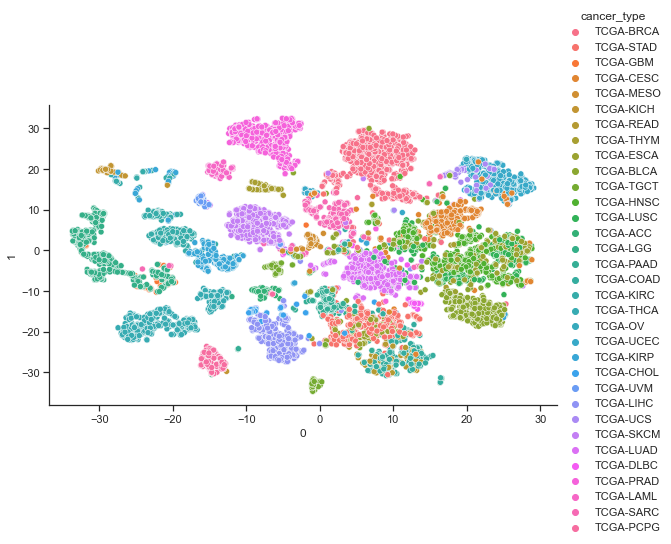

In [27]:
# CURRENT
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

cancer_types = grouped_tsne['cancer_type'].tolist()
cancer_types = list(set(cancer_types))

seaborn.relplot(data=grouped_tsne, x=0, y=1, hue='cancer_type', hue_order=cancer_types, aspect=1.61)
plt.show()

Relplot = A figure-level function for visualizing statistical relationships using two common approaches: scatter plots and line plots. relplot() combines a FacetGrid with one of two axes-level functions: scatterplot() (with kind="scatter" ; the default)

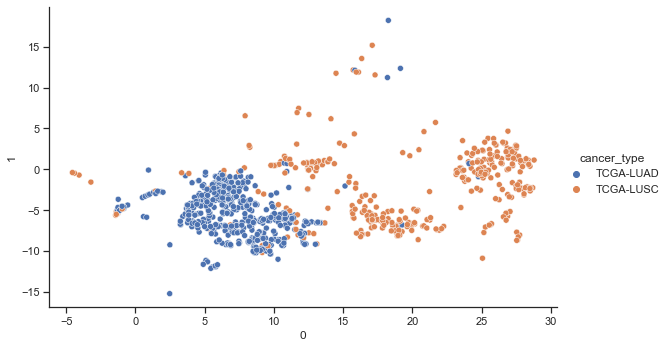

In [28]:
lung_cancer_types = ["TCGA-LUAD","TCGA-LUSC"] 
lung_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_cancer_types)]

seaborn.relplot(data=lung_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_cancer_types, aspect=1.61)
plt.show()

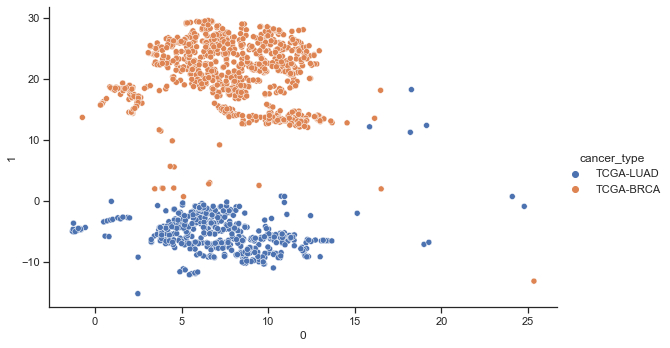

In [29]:
lung_breast_cancer_types = ["TCGA-LUAD","TCGA-BRCA"] 
lung_breast_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_breast_cancer_types)]

seaborn.relplot(data=lung_breast_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_breast_cancer_types, aspect=1.61)
plt.show()